In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import statsmodels.api as sm

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox

import seaborn as sns

from sklearn.metrics import mean_squared_error


In [67]:
import seaborn as sns
import sklearn

print(f"Seaborn version: {sns.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

Seaborn version: 0.13.2
Scikit-learn version: 1.6.1


# Caricamento e Preparazione dei Dati

Questa sezione del notebook si occupa del caricamento del dataset e della sua preparazione iniziale per l'analisi delle serie temporali.

Sono stati cricati i dati dal file data7.csv in un DataFrame pandas e abbiamo ispezionato le prime e ultime righe (.head(), .tail()) e le informazioni generali (.info()).

In [47]:
data= pd.read_csv("data7.csv", sep=';', header=None)

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1001 non-null   object
 1   1       1001 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [49]:
data.head()

,0,1
0,date,Y
1,2023-01-01,0.0
2,2023-01-02,0.05
3,2023-01-03,0.1
4,2023-01-04,-0.52


In [50]:
data.tail()

,0,1
996,2025-09-22,0.11
997,2025-09-23,-0.26
998,2025-09-24,-0.25
999,2025-09-25,-0.34
1000,2025-09-26,-0.2


## Pulizia e Formattazione dei Dati

In questa parte, i dati vengono puliti, convertiti nel formato corretto (la colonna dei valori è numeric, la colonna delle date in indice temporale), sono gestiti i valori mancanti.

In [51]:
data = data.iloc[1:].reset_index(drop=True) # rimuove prima riga con NaN

# Converte le colonne
data.iloc[:, 0] = pd.to_datetime(data.iloc[:, 0], errors="coerce")
data.iloc[:, 1] = pd.to_numeric(data.iloc[:, 1], errors="coerce")

# Rinomina le colonne
data.columns = ["date", "value"]

# Imposta l'indice
data = data.set_index("date")

/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2023-01-01 to 2025-09-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   value   1000 non-null   object
dtypes: object(1)
memory usage: 15.6+ KB


In [53]:
data.head()

,value
date,
2023-01-01,0.0
2023-01-02,0.05
2023-01-03,0.1
2023-01-04,-0.52
2023-01-05,-1.7


# Esplorazione

## Visualizzazione Iniziale della Serie

Il codice seguente visualizza la serie temporale grezza per osservare l'andamento generale nel tempo.

<Axes: title={'center': ' serie temporale'}, xlabel='date'>

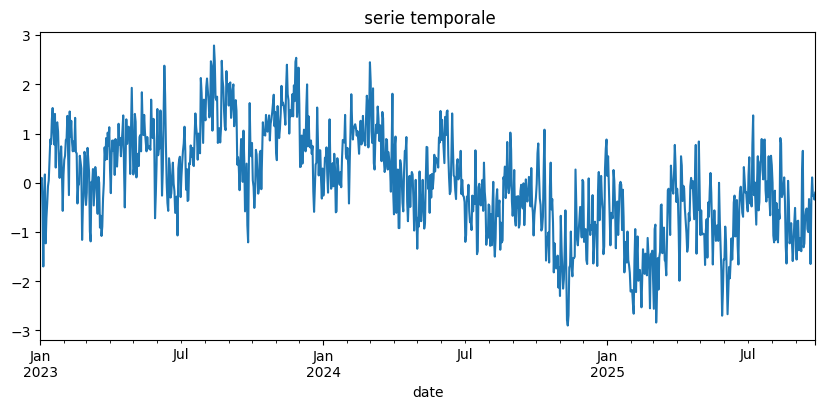

In [54]:
data['value'].plot(title = ' serie temporale', figsize=(10,4))

## Analisi di Autocorrelazione


<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

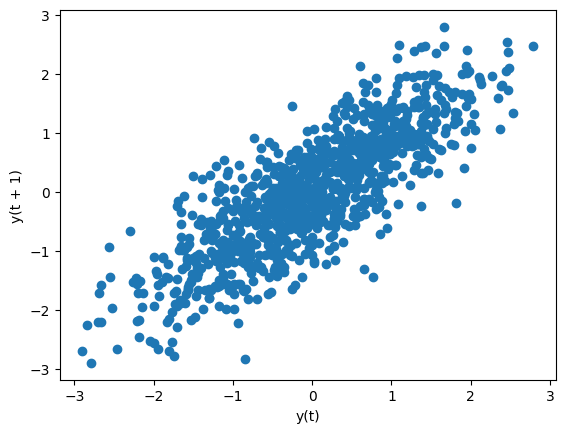

In [55]:

lag_plot(data['value'])


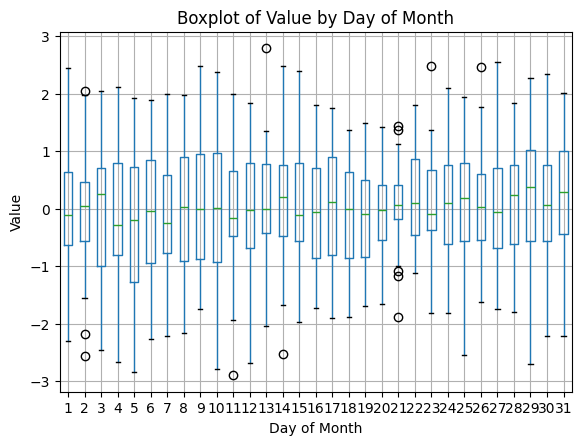

In [56]:
data['day'] = data.index.day
data.boxplot(column='value', by='day')
plt.title('Boxplot of Value by Day of Month')
plt.suptitle('') # Suppress the default suptitle
plt.xlabel('Day of Month')
plt.ylabel('Value')
plt.show()

## Analisi Spettrale (Periodogramma)

Il periodogramma viene calcolato per identificare le frequenze o periodi dominanti nella serie temporale.

Text(0, 0.5, 'Potenza')

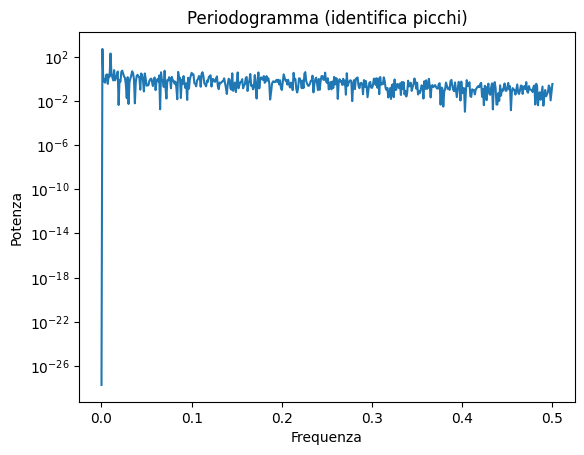

In [57]:
from scipy.signal import periodogram

freqs, power = periodogram(data['value'].dropna())
plt.semilogy(freqs, power)
plt.title("Periodogramma (identifica picchi)")
plt.xlabel("Frequenza")
plt.ylabel("Potenza")

In [58]:
from scipy.signal import periodogram
import numpy as np

y = data['value'].dropna()

freqs, psd = periodogram(y)

# Escludi la frequenza 0
mask = freqs > 0

freqs = freqs[mask]
psd = psd[mask]

# Calcola i periodi corrispondenti
periods = 1 / freqs

# Trova i 5 periodi principali
top_idx = np.argsort(psd)[-5:][::-1]
print("Top candidate periods (from periodogram):", np.round(periods[top_idx], 2))


Top candidate periods (from periodogram): [1000.    100.     71.43   43.48   14.29]


In [59]:
data.index.inferred_freq


'D'

# Test di stazionarietà

 Sono stati eseguiti test di Augmented Dickey-Fuller (ADF) e KPSS sulla serie originale per verificare la stazionarietà. I test inziali hanno suggerito una non stazionarietà della serie.

La serie è stata differenziata e sono stati ripetuti i testi ADF e KPSS, i riusltati sui dati differenziati hanno fornito una forte evidenza di stazionarietà.

In [60]:


adf_stat, adf_p = adfuller(data['value'].dropna())[0:2]
kpss_stat, kpss_p = kpss(data['value'].dropna(), regression='c')[0:2]

print(f"ADF p={adf_p:.3f}, KPSS p={kpss_p:.3f}")

ADF p=0.047, KPSS p=0.010


/tmp/ipython-input-1437933189.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p = kpss(data['value'].dropna(), regression='c')[0:2]


In [61]:
data['value_diff'] = data['value'].diff()
adf_stat, adf_p_diff = adfuller(data['value_diff'].dropna())[0:2]
kpss_stat, kpss_p_diff = kpss(data['value_diff'].dropna(), regression='c')[0:2]

print(f"ADF p={adf_p_diff:.3f}, KPSS p={kpss_p_diff:.3f}")


ADF p=0.000, KPSS p=0.100


/tmp/ipython-input-3728961570.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p_diff = kpss(data['value_diff'].dropna(), regression='c')[0:2]


# Analisi Percentuale dell'Impatto delle Frequenze (dal Periodogramma)

In [62]:

# Assicurrarsi che freqs e psd siano disponibili
# Assicurati che data_value_numeric sia disponibile (la serie pulita usata per il periodogramma)

# Rimuovi la frequenza 0 e il suo psd corrispondente
# (la frequenza 0 rappresenta la media o il trend costante e spesso domina il periodogramma)
mask = freqs > 0
freqs_nonzero = freqs[mask]
psd_nonzero = psd[mask]

# Calcola i periodi corrispondenti alle frequenze non nulle
periods_nonzero = 1 / freqs_nonzero

# Calcola la potenza totale (somma della potenza su tutte le frequenze non nulle)
total_power_nonzero = psd_nonzero.sum()

# Calcola la percentuale di potenza per ogni frequenza
percentage_power_nonzero = (psd_nonzero / total_power_nonzero) * 100

# Crea un DataFrame per visualizzare i risultati
spectral_analysis_df = pd.DataFrame({
    'Frequency': freqs_nonzero,
    'Period': periods_nonzero,
    'Power': psd_nonzero,
    'Percentage_Power': percentage_power_nonzero
})

# Ordina per percentuale di potenza decrescente e mostra le prime N
spectral_analysis_df = spectral_analysis_df.sort_values(by='Percentage_Power', ascending=False)

print("Frequenze/Periodi per Contributo Percentuale alla Varianza (esclusa Freq 0):")
display(spectral_analysis_df.head(10)) # Mostra i primi 10 periodi più impattanti

print("\nContributo percentuale di periodi specifici (approssimati):")

# Funzione per trovare la percentuale di potenza per un periodo target (approssimato)
def get_percentage_for_period(target_period, periods_df, tolerance=0.5):
    """Trova la percentuale di potenza per un periodo target con una certa tolleranza."""
    # Trova i periodi nel DataFrame che sono vicini al periodo target
    close_periods_mask = np.abs(periods_df['Period'] - target_period) <= tolerance
    if close_periods_mask.any():
        # Somma la percentuale di potenza per tutti i periodi vicini
        total_percentage = periods_df.loc[close_periods_mask, 'Percentage_Power'].sum()
        return total_percentage
    else:
        return 0.0

# Periodi di interesse
periods_of_interest = {
    'Annual (365)': 365,
    'Weekly (7)': 7,
    'Approx 3 months (100)': 100, # Dai top periodi
    'Approx 2.3 months (71.43)': 71.43, # Dai top periodi
    'Approx 1.4 months (43.48)': 43.48, # Dai top periodi
    'Approx 2 weeks (14.29)': 14.29 # Dai top periodi
}

for name, period in periods_of_interest.items():
    percentage = get_percentage_for_period(period, spectral_analysis_df, tolerance=0.5) # Usa una tolleranza di 0.5 giorni
    print(f"- {name} (Periodo ~{period:.2f} giorni): {percentage:.4f}%")

Frequenze/Periodi per Contributo Percentuale alla Varianza (esclusa Freq 0):


,Frequency,Period,Power,Percentage_Power
0,0.001,1000.000000,523.623456,49.440909
9,0.010,100.000000,201.673228,19.042134
13,0.014,71.428571,6.271684,0.592177
22,0.023,43.478261,5.662176,0.534627
69,0.070,14.285714,5.474013,0.51686
33,0.034,29.411765,4.906917,0.463315
17,0.018,55.555556,4.65984,0.439985
21,0.022,45.454545,4.430953,0.418374
84,0.085,11.764706,4.331357,0.40897
225,0.226,4.424779,4.143887,0.391269



Contributo percentuale di periodi specifici (approssimati):
- Annual (365) (Periodo ~365.00 giorni): 0.0000%
- Weekly (7) (Periodo ~7.00 giorni): 1.3480%
- Approx 3 months (100) (Periodo ~100.00 giorni): 19.0421%
- Approx 2.3 months (71.43) (Periodo ~71.43 giorni): 0.5922%
- Approx 1.4 months (43.48) (Periodo ~43.48 giorni): 0.5346%
- Approx 2 weeks (14.29) (Periodo ~14.29 giorni): 0.6167%


# Modellazione con Sinusoidi (Periodi 1000 e 100) tramite Regressione OLS

DataFrame dei regressori (termini di Fourier) creato.


,const,sin_1000,cos_1000,sin_100,cos_100
date,,,,,
2023-01-01,1.0,0.000000,1.000000,0.000000,1.000000
2023-01-02,1.0,0.006283,0.999980,0.062791,0.998027
2023-01-03,1.0,0.012566,0.999921,0.125333,0.992115
2023-01-04,1.0,0.018848,0.999822,0.187381,0.982287
2023-01-05,1.0,0.025130,0.999684,0.248690,0.968583



Modello OLS addestrato.
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     540.5
Date:                Wed, 15 Oct 2025   Prob (F-statistic):          1.15e-247
Time:                        17:33:20   Log-Likelihood:                -870.32
No. Observations:                1000   AIC:                             1751.
Df Residuals:                     995   BIC:                             1775.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0075      

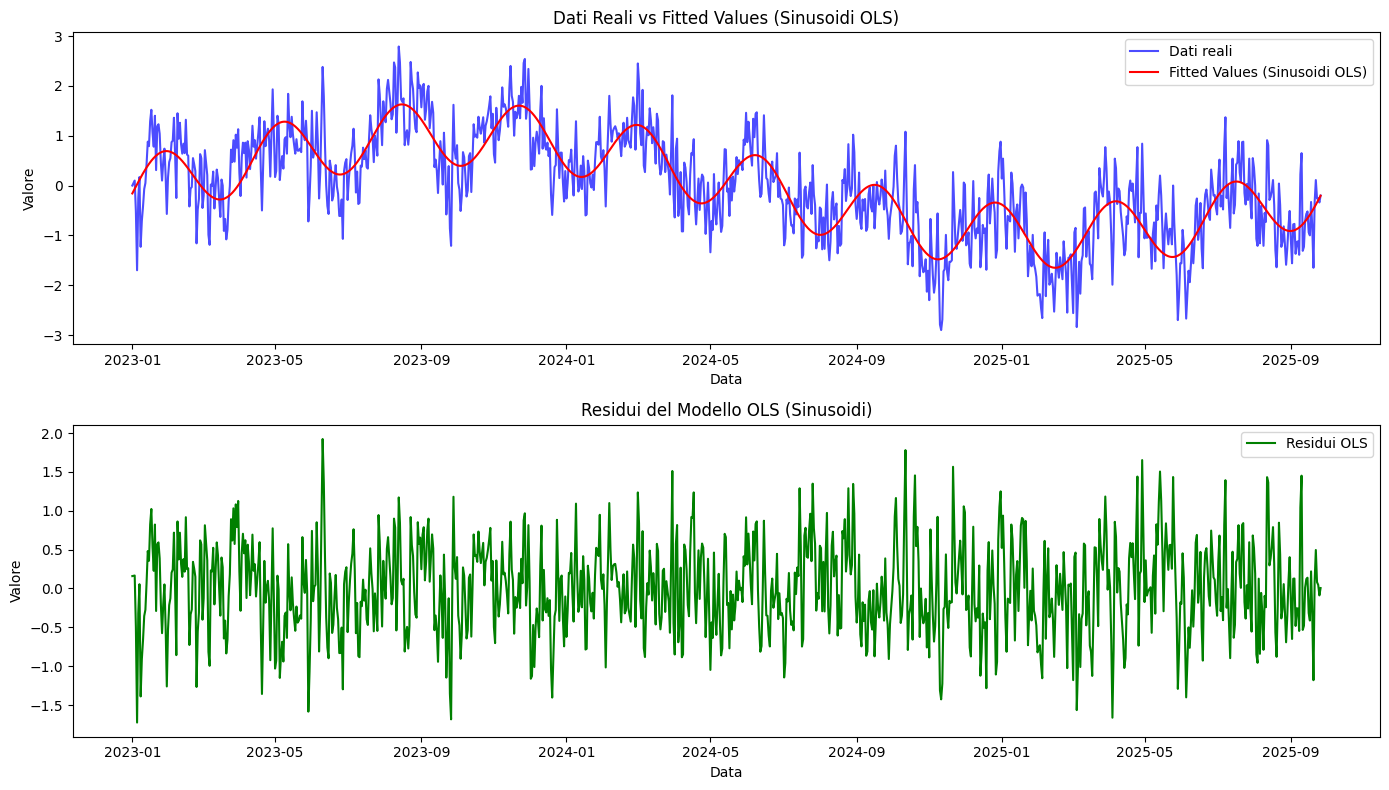


Analisi di correlazione sui residui OLS:


<Figure size 1200x400 with 0 Axes>

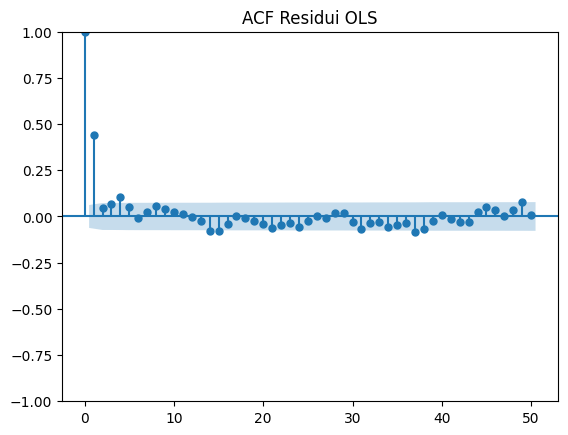

<Figure size 1200x400 with 0 Axes>

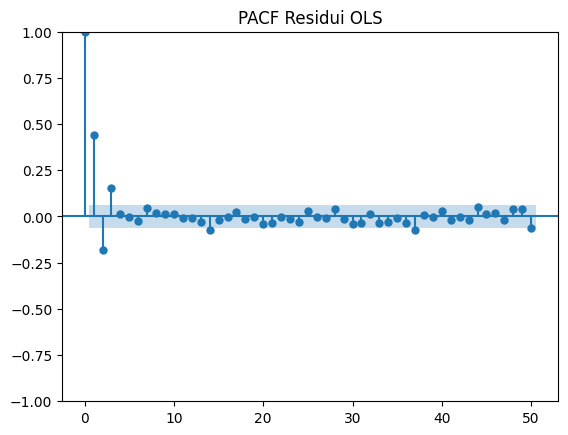


Risultati Ljung-Box Test sui Residui OLS:


,lb_stat,lb_pvalue
10,220.907583,6.900940e-42
20,237.978463,3.001097e-39
30,250.972478,9.836747e-37


In [63]:
# Assicurati che data_value_numeric sia disponibile (serie originale pulita)
# (esegui le celle iniziali per caricare e preparare i dati se necessario)

# Creare un DataFrame per i regressori (termini di Fourier)
# Usiamo l'indice di data_value_numeric per assicurarci che l'allineamento sia corretto
fourier_df = pd.DataFrame(index=data['value'].index)

# Definire i periodi per le sinusoidi
period_long = 1000
period_short = 100

# Convertire l'indice temporale in un formato numerico (es. giorni dall'inizio)
# per calcolare le fasi delle sinusoidi
time_index_numeric = (data['value'].index - data['value'].index[0]).days

# Generare i termini seno e coseno per ogni periodo
fourier_df[f'sin_{period_long}'] = np.sin(2 * np.pi * time_index_numeric / period_long)
fourier_df[f'cos_{period_long}'] = np.cos(2 * np.pi * time_index_numeric / period_long)

fourier_df[f'sin_{period_short}'] = np.sin(2 * np.pi * time_index_numeric / period_short)
fourier_df[f'cos_{period_short}'] = np.cos(2 * np.pi * time_index_numeric / period_short)

# Aggiungere una costante per l'intercetta nel modello OLS
fourier_df = sm.add_constant(fourier_df)

print("DataFrame dei regressori (termini di Fourier) creato.")
display(fourier_df.head())

# =======================================================================
# Addestrare il modello OLS
# =======================================================================

# Definire la variabile dipendente (la serie originale)
y = data['value'].astype(float)

# Definire le variabili indipendenti (i termini di Fourier + costante)
X = fourier_df

# Addestrare il modello OLS
try:
    model_ols = sm.OLS(y, X)
    results_ols = model_ols.fit()

    print("\nModello OLS addestrato.")
    print(results_ols.summary())

    # =======================================================================
    # Analisi dei risultati OLS
    # =======================================================================

    # Ottenere i valori fittati dal modello OLS (la somma delle sinusoidi stimate)
    fitted_values_ols = results_ols.predict(X)

    # Ottenere i residui del modello OLS
    residuals_ols = results_ols.resid

    # Plot della serie originale, valori fittati e residui
    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    plt.plot(y.index, y.values, label='Dati reali', color='blue', alpha=0.7)
    plt.plot(fitted_values_ols.index, fitted_values_ols.values, label='Fitted Values (Sinusoidi OLS)', color='red')
    plt.title('Dati Reali vs Fitted Values (Sinusoidi OLS)')
    plt.xlabel('Data')
    plt.ylabel('Valore')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(residuals_ols.index, residuals_ols.values, label='Residui OLS', color='green')
    plt.title('Residui del Modello OLS (Sinusoidi)')
    plt.xlabel('Data')
    plt.ylabel('Valore')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # (Opzionale) Analisi di correlazione sui residui OLS
    print("\nAnalisi di correlazione sui residui OLS:")
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from statsmodels.stats.diagnostic import acorr_ljungbox

    residuals_ols_clean = residuals_ols.dropna()

    plt.figure(figsize=(12, 4))
    plot_acf(residuals_ols_clean, lags=50)
    plt.title('ACF Residui OLS')
    plt.show()

    plt.figure(figsize=(12, 4))
    plot_pacf(residuals_ols_clean, lags=50)
    plt.title('PACF Residui OLS')
    plt.show()

    lb_test_results_ols = acorr_ljungbox(residuals_ols_clean, lags=[10, 20, 30], return_df=True)
    print("\nRisultati Ljung-Box Test sui Residui OLS:")
    display(lb_test_results_ols)


except Exception as e:
    print(f"Errore durante l'addestramento o l'analisi del modello OLS: {e}")

# Fitting di un Modello dei residui

Fitting modello ARIMA(1,1,1) sui residui OLS (2023-01-01 - 2025-09-26)...

Modello ARIMA(1,0,1) addestrato sui residui OLS.
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -732.884
Date:                Wed, 15 Oct 2025   AIC                           1473.769
Time:                        17:33:21   BIC                           1493.388
Sample:                    01-01-2023   HQIC                          1481.226
                         - 09-26-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5479      0.033     16.849      0.000       0.484       0.612
ar.L2  

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<Figure size 1200x400 with 0 Axes>

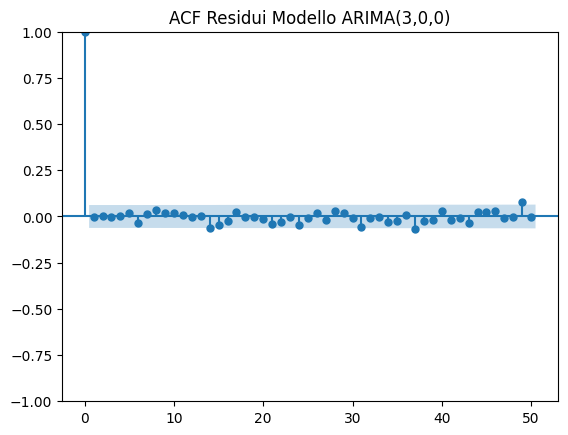

<Figure size 1200x400 with 0 Axes>

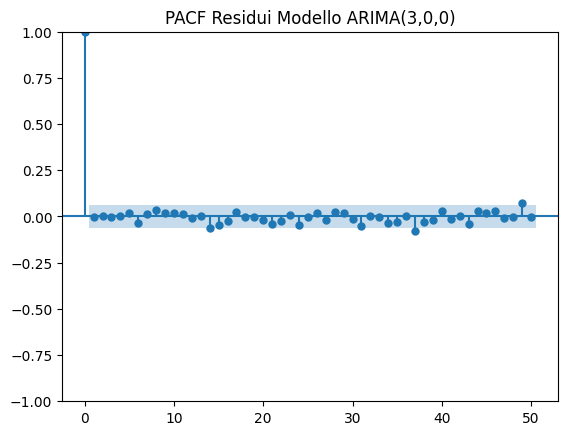


Risultati Ljung-Box Test sui Residui Modello ARIMA(1,0,0):


,lb_stat,lb_pvalue
10,3.909880,0.951321
20,11.440937,0.933977
30,18.216007,0.954930



Interpretazione Ljung-Box Test sui Residui ARIMA:
- Se i p-value sono > 0.05, i residui sono probabilmente rumore bianco.
- Se i p-value sono <= 0.05, ci sono ancora correlazioni residue significative.


In [64]:




# Rimuovi eventuali NaN dai residui OLS prima del fitting ARIMA
residuals_ols_clean = residuals_ols.dropna()

print(f"Fitting modello ARIMA(1,1,1) sui residui OLS ({residuals_ols_clean.index.min().date()} - {residuals_ols_clean.index.max().date()})...")

# Definire e addestrare il modello ARIMA(3,0,0)
# Usiamo SARIMAX con order=(p,d,q) e seasonal_order=(0,0,0,0)
try:
    model_arima = SARIMAX(residuals_ols_clean,
                          order=(3,0,0), # p=1, d=1 (differenziazione), q=1
                          seasonal_order=(0,0,0,0), # Non stagionale
                          enforce_stationarity=False, # Manteniamo disabilitato l'enforcement
                          enforce_invertibility=False)

    results_arima = model_arima.fit(disp=False)

    print("\nModello ARIMA(1,0,1) addestrato sui residui OLS.")
    print(results_arima.summary())

    # =======================================================================
    # Analisi dei Residui del Modello ARIMA(3,0,0)
    # =======================================================================

    arima_residuals = results_arima.resid

    print("\nAnalisi dei Residui del Modello ARIMA(3,0,0):")

    # Plot ACF e PACF dei residui ARIMA
    plt.figure(figsize=(12, 4))
    plot_acf(arima_residuals, lags=50)
    plt.title('ACF Residui Modello ARIMA(3,0,0)')
    plt.show()

    plt.figure(figsize=(12, 4))
    plot_pacf(arima_residuals, lags=50)
    plt.title('PACF Residui Modello ARIMA(3,0,0)')
    plt.show()

    # Ljung-Box Test sui residui ARIMA
    lb_test_results_arima = acorr_ljungbox(arima_residuals, lags=[10, 20, 30], return_df=True)
    print("\nRisultati Ljung-Box Test sui Residui Modello ARIMA(1,0,0):")
    display(lb_test_results_arima)

    print("\nInterpretazione Ljung-Box Test sui Residui ARIMA:")
    print("- Se i p-value sono > 0.05, i residui sono probabilmente rumore bianco.")
    print("- Se i p-value sono <= 0.05, ci sono ancora correlazioni residue significative.")


except Exception as e:
    print(f"Errore durante l'addestramento o l'analisi del modello ARIMA: {e}")
    print("Assicurati che 'residuals_ols' sia definito e contenga dati sufficienti.")

# Valutazione Modello Combinato: OLS(Sinusoidi) + AR(3) sui Residui OLS (Cross-Validation)

In [65]:
# Definire le dimensioni dei folds
# Utilizziamo la serie di dati originale (pulita)
n_total = len(data) # Usa la lunghezza dei dati puliti
initial_train_size = 365  # Dimensione iniziale del training set (almeno per un ciclo annuale)
n_test_folds = 5
# Calcola la dimensione approssimativa di ogni blocco di test
test_block_size = (n_total - initial_train_size) // n_test_folds

# Lista per salvare i risultati (valori reali e forecast combinato)
all_actual_combined = []
all_forecast_combined = []
fold_errors_combined = [] # Per salvare metriche per ogni fold (opzionale)

# Definire i periodi delle sinusoidi (corrispondenti a OLS)
period_long = 1000
period_short = 100

# =======================================================================
# Pre-calcolare i regressori sinusoidali per l'intera serie una volta sola
# =======================================================================
print("Pre-calcolo dei regressori sinusoidali per l'intera serie...")

# Creare un DataFrame per i regressori (termini di Fourier) per l'intera serie
# Usiamo l'index di data['value'] per assicurarci che l'allineamento sia corretto
fourier_regressors_full = pd.DataFrame(index=data['value'].index)

# Usiamo un semplice index intero sequenziale per calcolare le fasi delle sinusoidi
# Inizia da 0 per la prima osservazione
time_index_numeric_full = np.arange(n_total)

# Generare i termini seno e coseno per ogni periodo per l'intera serie
fourier_regressors_full[f'sin_{period_long}'] = np.sin(2 * np.pi * time_index_numeric_full / period_long)
fourier_regressors_full[f'cos_{period_long}'] = np.cos(2 * np.pi * time_index_numeric_full / period_long)
fourier_regressors_full[f'sin_{period_short}'] = np.sin(2 * np.pi * time_index_numeric_full / period_short)
fourier_regressors_full[f'cos_{period_short}'] = np.cos(2 * np.pi * time_index_numeric_full / period_short)

# Aggiungere una costante per l'intercetta nel modello OLS
fourier_regressors_full = sm.add_constant(fourier_regressors_full)

print("Regressori sinusoidali pre-calcolati.")
# display(fourier_regressors_full.head())


print(f"Dimensione totale dati (puliti): {n_total}")
print(f"Dimensione training iniziale: {initial_train_size}")
print(f"Dimensione approssimativa blocco test: {test_block_size}")
print("-" * 30)

# Funzione per eseguire OLS + AR(3) e generare forecast per un singolo fold CV
# Ora prende i regressori pre-calcolati per training e test
def ols_ar3_combined_forecast_fold(train_data_value, test_data_value, X_train_ols, X_test_ols):
    """
    Addestra OLS con sinusoidi (1000, 100) sul training data usando regressori pre-calcolati.
    Addestra AR(3) sui residui OLS del training data.
    Genera forecast combinato (OLS + AR(3)) per il periodo del test data.

    Ritorna:
    - full_forecast: valori previsti per il periodo di test (combinazione di OLS e AR3 forecast)
    - ols_results: risultati del modello OLS addestrato
    - ar3_results: risultati del modello AR(3) addestrato
    """
    # 1️⃣ Pulizia dati (solo sul training)
    train_data_clean = train_data_value.dropna().astype(float) # Assicurati che sia float

    # Aggiungi controllo per dati di training vuoti o tutti NaN
    if train_data_clean.empty or train_data_clean.isnull().all():
        print("Warning: Training data clean è vuoto o tutti NaN dopo dropna(). Saltato il fold.")
        return pd.Series(dtype='float64'), None, None # Ritorna Serie vuota e None per i modelli

    # Assicurati che i regressori di training siano allineati con i dati di training puliti
    X_train_ols_clean = X_train_ols.loc[train_data_clean.index]


    # Verifico se i dati di training sono sufficienti per OLS e AR(3)
    # OLS richiede almeno (numero di regressori + 1) osservazioni
    num_ols_regressors = X_train_ols_clean.shape[1] - 1 # Numero di colonne - 1 (per la costante)
    min_length_ols = num_ols_regressors + 1
    # AR(3) richiede almeno 3 osservazioni (per i parametri AR) + differenziazione se presente (qui d=0)
    min_length_ar3 = 3 + 0 # Per AR(3)

    if len(train_data_clean) < max(min_length_ols, min_length_ar3):
        print(f"Warning: Training data troppo corto ({len(train_data_clean)} giorni) per OLS/AR3 ({max(min_length_ols, min_length_ar3)} richiesti). Saltato il fold.")
        return pd.Series(dtype='float64'), None, None # Ritorna Serie vuota e None per i modelli


    # 3️⃣ Addestrare il modello OLS sui dati di training del fold con i regressori pre-calcolati
    try:
        model_ols = sm.OLS(train_data_clean, X_train_ols_clean)
        results_ols = model_ols.fit()
    except Exception as e:
        print(f"Errore durante il fit del modello OLS nel fold: {e}")
        return pd.Series(dtype='float64'), None, None


    # 4️⃣ Calcolare i residui OLS sul training data
    residuals_ols_train = results_ols.resid.dropna() # Rimuovi eventuali NaN

    # Aggiungi controllo per residui OLS vuoti o tutti NaN
    if residuals_ols_train.empty or residuals_ols_train.isnull().all():
        print("Warning: Residui OLS training è vuoto o tutti NaN. Saltato il fold.")
        return pd.Series(dtype='float64'), results_ols, None # Ritorna Serie vuota e OLS results


    # Verifico se i residui OLS sono sufficienti per AR(3)
    if len(residuals_ols_train) < min_length_ar3:
         print(f"Warning: Residui OLS training troppo corti ({len(residuals_ols_train)} giorni) per AR(3). Saltato il fold.")
         return pd.Series(dtype='float64'), results_ols, None # Ritorna Serie vuota e OLS results


    # 5️⃣ Addestrare il modello AR(3) sui residui OLS del training data
    try:
        # Usiamo SARIMAX con order=(3,0,0) per un modello AR(3) non stagionale
        model_ar3 = SARIMAX(residuals_ols_train,
                            order=(3,0,0), # p=3, d=0, q=0
                            seasonal_order=(0,0,0,0), # Non stagionale
                            enforce_stationarity=False, # Manteniamo disabilitato l'enforcement
                            enforce_invertibility=False)

        results_ar3 = model_ar3.fit(disp=False)
    except Exception as e:
        print(f"Errore durante il fit del modello AR(3) sui residui OLS nel fold: {e}")
        return pd.Series(dtype='float64'), results_ols, None # Ritorna Serie vuota e OLS results


    # 6️⃣ Generare forecast OLS per il periodo di test
    try:
        # Assicurati che X_test_ols abbia le stesse colonne di X_train_ols usate nel fit
        # Riorganizza le colonne di X_test_ols per corrispondere a quelle di X_train_ols
        X_test_ols_aligned = X_test_ols[X_train_ols_clean.columns]
        forecast_ols_test = results_ols.predict(X_test_ols_aligned)
    except Exception as e:
        print(f"Errore durante predict OLS nel fold: {e}")
        return pd.Series(dtype='float64'), results_ols, results_ar3


    # 7️⃣ Generare forecast AR(3) per il periodo di test
    try:
        # Il forecast AR(3) è un forecast dei residui
        # Usa l'index del test_data_value per il forecast
        forecast_ar3_test = results_ar3.get_forecast(steps=len(test_data_value.index), index=test_data_value.index).predicted_mean
    except Exception as e:
        print(f"Errore durante get_forecast AR(3) nel fold: {e}")
        return pd.Series(dtype='float64'), results_ols, results_ar3


    # 8️⃣ Combinare i due forecast
    # Assicurati che entrambi i forecast abbiano lo stesso index (test_data_value.index) e siano numerici
    # Usiamo .add per sommare, gestendo eventuali disallineamenti (non dovrebbero esserci)
    try:
        full_forecast = forecast_ols_test.add(forecast_ar3_test, fill_value=0.0).dropna()
    except Exception as e:
         print(f"Errore durante la combinazione dei forecast nel fold: {e}")
         return pd.Series(dtype='float64'), results_ols, results_ar3


    return full_forecast, results_ols, results_ar3


# Loop per la cross-validation
# Usiamo enumerate per avere l'index i e i dati effettivi del fold
for i, (train_index_full, test_index_full) in enumerate(zip(
    [data['value'].iloc[:initial_train_size + j * test_block_size].index for j in range(n_test_folds)],
    [data['value'].iloc[initial_train_size + j * test_block_size : min(initial_train_size + (j+1) * test_block_size, n_total)].index for j in range(n_test_folds)]
)):
    # Corregge l'index dell'ultimo test fold per arrivare alla fine
    if i == n_test_folds - 1:
         test_index_full = data['value'].iloc[initial_train_size + i * test_block_size : n_total].index


    print(f"Esecuzione Fold {i+1}/{n_test_folds}...")

    # Ottieni i dati (solo la colonna value pulita) per il fold corrente usando gli indici temporali
    train_data_value_fold = data['value'].loc[train_index_full]
    test_data_value_fold = data['value'].loc[test_index_full]

    # Ottieni i regressori pre-calcolati per il fold corrente usando gli stessi indici temporali
    X_train_ols_fold = fourier_regressors_full.loc[train_index_full]
    X_test_ols_fold = fourier_regressors_full.loc[test_index_full]


    # Aggiungi controllo esplicito per dati di training vuoti o tutti NaN prima di chiamare la funzione
    if train_data_value_fold.empty or train_data_value_fold.isnull().all():
         print(f"  Saltato Fold {i+1}: Dati di training vuoti o tutti NaN prima di elaborazione.")
         continue # Passa al fold successivo

    # Se il test set è vuoto o troppo piccolo, interrompi
    if test_data_value_fold.empty or len(test_data_value_fold) < 1:
        print(f"  Saltato Fold {i+1}: Test set vuoto o troppo piccolo.")
        continue # Usa continue per passare al fold successivo


    print(f"  Training data shape: {train_data_value_fold.shape}")
    print(f"  Test data shape: {test_data_value_fold.shape}")

    # Salva le lunghezze iniziali per debugging
    len_train_initial = len(train_data_value_fold)
    len_test_initial = len(test_data_value_fold)

    try:
        # Esegui il forecast combinato per il test set del fold corrente
        # Passiamo le fette di dati e i regressori pre-calcolati per il fold
        forecast_fold, ols_results_fold, ar3_results_fold = ols_ar3_combined_forecast_fold(
            train_data_value_fold,
            test_data_value_fold, # Passiamo l'intera fetta del test data slice
            X_train_ols_fold,     # Passiamo i regressori OLS per il training del fold
            X_test_ols_fold       # Passiamo i regressori OLS per il test del fold
        )

        # Salva i valori reali e i forecast per questo fold
        # forecast_fold ha già l'index del test set, quindi non serve reindexare actual_fold_values
        actual_fold_values = test_data_value_fold.astype(float) # Assicurati che anche i reali siano float

        # Assicurati che forecast_fold e actual_fold_values abbiano lo stesso index prima di appendere
        # Utilizziamo .align con 'inner' join per confrontare solo date comuni per error e appendere
        # Solo se forecast_fold non è vuoto e non contiene NaN
        if not forecast_fold.empty and not forecast_fold.isnull().all():
            actual_aligned_for_error, forecast_aligned_for_error = actual_fold_values.align(
                forecast_fold, join='inner', axis=0, fill_value=np.nan # Usiamo inner join per confrontare solo date comuni
            )

            # Rimuovi eventuali NaN che potrebbero derivare dal fill_value dell'align
            actual_aligned_for_error = actual_aligned_for_error.dropna()
            forecast_aligned_for_error = forecast_aligned_for_error.dropna()


            if not actual_aligned_for_error.empty and not forecast_aligned_for_error.empty:
                all_actual_combined.append(actual_aligned_for_error)
                all_forecast_combined.append(forecast_aligned_for_error)

                # Calcola e stampa l'error per the fold corrente (opzionale)
                mse_fold = mean_squared_error(actual_aligned_for_error, forecast_aligned_for_error)
                print(f"  MSE Fold {i+1}: {mse_fold:.4f}")
                fold_errors_combined.append({'fold': i+1, 'mse': mse_fold})
            else:
                 print(f"  Nessun dato valido per calcolare l'error e nel Fold {i+1} dopo allineamento e dropna.")
        else:
             print(f"  Forecast vuoto o contiene solo NaN per il Fold {i+1}.")


    except Exception as e:
        print(f"  Errore durante l'elaborazione del Fold {i+1}: {e}")
        # Puoi scegliere di interrompere o continuare
        # break # Non usare break se vuoi che il loop continui anche in caso di error in un fold


print("-" * 30)
print("Cross-validation completata.")

# Concatena i risultati di tutti i folds
if all_actual_combined and all_forecast_combined:
    # Utilizza .align con 'inner' join per concatenare solo le date comuni tra reali e forecast su tutti i folds
    # Questo assicura che stiamo confrontando solo le date per cui abbiamo sia valori reali che previsti
    try:
        all_actual_concat_combined = pd.concat(all_actual_combined)
        all_forecast_concat_combined = pd.concat(all_forecast_combined)

        all_actual_final_combined, all_forecast_final_combined = all_actual_concat_combined.align(
            all_forecast_concat_combined, join='inner', axis=0, fill_value=np.nan
        )
        all_actual_final_combined = all_actual_final_combined.dropna()
        all_forecast_final_combined = all_forecast_final_combined.dropna()


        print(f"Totale punti reali raccolti per MSE globale: {len(all_actual_final_combined)}")
        print(f"Totale punti previsti raccolti per MSE globale: {len(all_forecast_final_combined)}")


        # Calcola l'MSE globale sulla cross-validation
        if len(all_actual_final_combined) > 0 and len(all_actual_final_combined) == len(all_forecast_final_combined):
            global_mse_combined = mean_squared_error(all_actual_final_combined, all_forecast_final_combined)
            print(f"\nMean Squared Error (MSE) globale sulla Cross-Validation (OLS+AR3): {global_mse_combined:.4f}")
        else:
            print("\nImpossibile calcolare l'MSE globale a causa di disallineamento o mancanza di dati dopo l'allineamento finale.")

    except Exception as e:
         print(f"Errore durante la concatenazione o il calcolo MSE globale: {e}")
         print("Impossibile calcolare l'MSE globale.")

else:
    print("Nessun dato raccolto durante la cross-validation.")

Pre-calcolo dei regressori sinusoidali per l'intera serie...
Regressori sinusoidali pre-calcolati.
Dimensione totale dati (puliti): 1000
Dimensione training iniziale: 365
Dimensione approssimativa blocco test: 127
------------------------------
Esecuzione Fold 1/5...
  Training data shape: (365,)
  Test data shape: (127,)
  MSE Fold 1: 0.2753
Esecuzione Fold 2/5...
  Training data shape: (492,)
  Test data shape: (127,)
  MSE Fold 2: 0.2922
Esecuzione Fold 3/5...
  Training data shape: (619,)
  Test data shape: (127,)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

  MSE Fold 3: 0.4044
Esecuzione Fold 4/5...
  Training data shape: (746,)
  Test data shape: (127,)
  MSE Fold 4: 0.4171
Esecuzione Fold 5/5...
  Training data shape: (873,)
  Test data shape: (127,)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


  MSE Fold 5: 0.3287
------------------------------
Cross-validation completata.
Totale punti reali raccolti per MSE globale: 635
Totale punti previsti raccolti per MSE globale: 635

Mean Squared Error (MSE) globale sulla Cross-Validation (OLS+AR3): 0.3435


# Visualizzazione Risultati Cross-Validation: OLS(Sinusoidi) + AR(3)

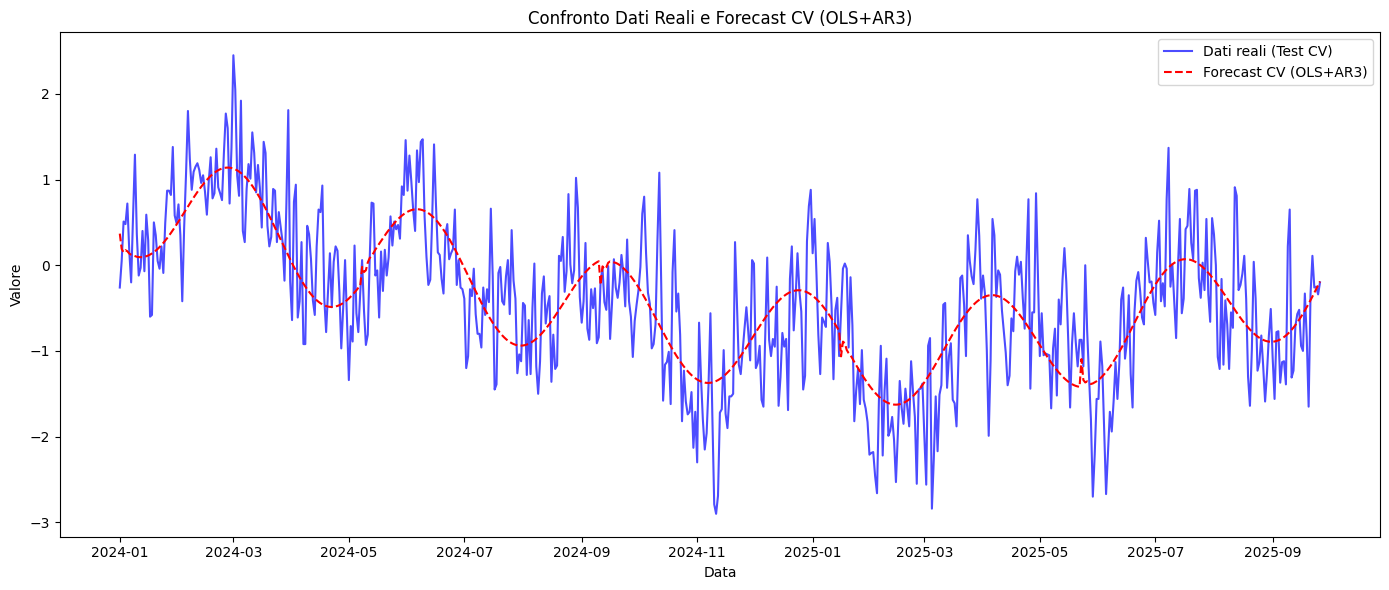

In [66]:

# Plot dei dati reali e dei forecast dalla cross-validation
plt.figure(figsize=(14, 6))

# Plot dei dati reali (combinati da tutti i test set)
if 'all_actual_final_combined' in locals() and not all_actual_final_combined.empty:
    plt.plot(all_actual_final_combined.index, all_actual_final_combined.values, label='Dati reali (Test CV)', color='blue', alpha=0.7)
else:
    print("Attenzione: all_actual_final_combined non definito o vuoto.")


# Plot dei forecast (combinati da tutti i test set)
if 'all_forecast_final_combined' in locals() and not all_forecast_final_combined.empty:
    plt.plot(all_forecast_final_combined.index, all_forecast_final_combined.values, label='Forecast CV (OLS+AR3)', color='red', linestyle='--')
else:
     print("Attenzione: all_forecast_final_combined non definito o vuoto.")


plt.title('Confronto Dati Reali e Forecast CV (OLS+AR3)')
plt.xlabel('Data')
plt.ylabel('Valore')
plt.legend()
plt.tight_layout()
plt.show()

# Sintesi


-**Caricamento e Pulizia dei Dati**: Il notebook ha iniziato caricando i dati da un file CSV. Successivamente, la serie temporale è stata pulita, convertendo la colonna dei valori in un formato numerico e impostando la colonna delle date come indice temporale del DataFrame, gestendo eventuali valori mancanti.

-**Analisi Esplorativa Iniziale**: È stata condotta un'analisi esplorativa iniziale. La serie temporale è stata visualizzata per osservare trend e pattern generali. Le funzioni di autocorrelazione (ACF) e autocorrelazione parziale (PACF) sono state calcolate per identificare dipendenze temporali e stagionalità.

-**Analisi Spettrale (Periodogramma)**: Il periodogramma è stato calcolato per identificare le frequenze o periodi dominanti nella serie temporale, identificando in particolare periodi di circa 1000 e 100 giorni come i più impattanti in termini di potenza.

-**Modellazione con Sinusoidi (OLS + AR(3))**: È stato esplorato un approccio di modellazione basato sui risultati del periodogramma, modellando la serie come somma di sinusoidi per i periodi dominanti (~1000 e ~100 giorni) più un componente residuo. È stato utilizzato un modello OLS per fittare le sinusoidi.
L'analisi dei residui OLS ha mostrato correlazioni significative, suggerendo la necessità di modellare questi residui. Un modello AR(3) è stato identificato come adatto per catturare queste correlazioni residue (residui dell'AR(3) sono risultati rumore bianco).

-**Validazione Modello Combinato OLS + AR(3) (Cross-Validation)**: Il modello combinato (OLS con sinusoidi + AR(3) sui residui OLS) è stato implementato e validato tramite cross-validation a 5 folds. Questo modello ha ottenuto l'MSE globale più basso .

-**Analisi Comparativa e Finale**: Le prestazioni del modello OLS+AR(3) sono state analizzate (principalmente tramite MSE globale e visualizzazione dei forecast sulla CV). Il modello è risultato il più performante e ha mostrato un ottimo adattamento visivo ai dati reali nei periodi di test.